## Brief description of the problem and data

### Problem Description

The Kaggle challenge involves constructing an algorithm to detect cancer in small image patches extracted from larger digital pathology slides. Specifically, the task is to predict the probability that the central 32x32 pixel region of each image patch contains at least one pixel of tumor tissue.

Data Structure and Details
The dataset is derived from the PatchCamelyon (PCam) benchmark dataset. Each image patch represents a small region of a pathology slide, designed to be processed quickly. The central 32x32px area of each patch is what determines the tumor presence label. Each image patch contains additional outer regions beyond the central 32x32px core, which supports models using fully convolutional layers without zero-padding. The train_labels.csv: contains ground truth labels for training images, identifying each image by its ID. Test images are not lables, and the task is to predict their probability of containing tumor tissue. The dataset is relatively large, and provides ample examples to train a deep learning model for image classification.

I will use a convolutional neural network (CNNs) becasue this class of model is typically effective in extracting patterns from data.

### Exploratory data analysis
Import libraries and load training labels

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

import warnings
warnings.filterwarnings('ignore')

train_labels = pd.read_csv('data/train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The label column provides a binary classification: 0 for no tumor, 1 for tumor presence in the 32x32px image

In [2]:
# Check for null values and basic statistics
train_labels.info()
train_labels['label'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

### Label distribution

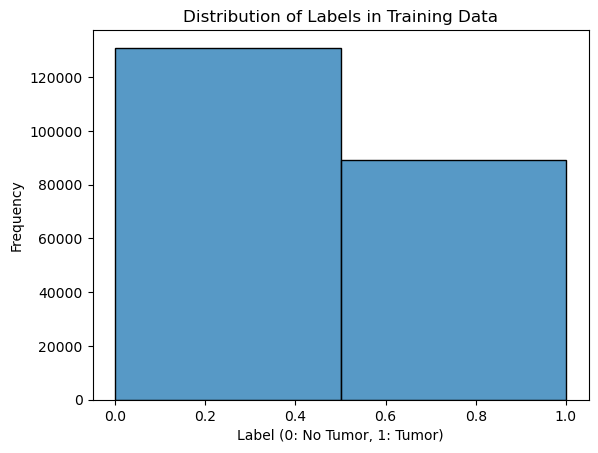

In [3]:
sns.histplot(train_labels['label'], kde=False, bins=2)
plt.xlabel('Label (0: No Tumor, 1: Tumor)')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Data')
plt.show()

There appears to be a modest imbalance in the data distribution with approximately 400k more images showing no cancer. I may need to explore sampling techniques or weighting the classes during model training.

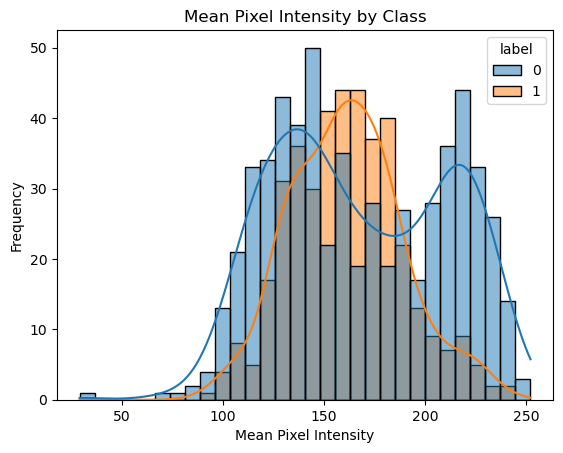

In [4]:
import numpy as np

def calculate_mean_intensity(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)
    return np.mean(image_array)

sample_data = train_labels.sample(1000)
sample_data['mean_intensity'] = sample_data['id'].apply(lambda x: calculate_mean_intensity(os.path.join('data/train', f'{x}.tif')))

sns.histplot(data=sample_data, x='mean_intensity', hue='label', bins=30, kde=True)
plt.title('Mean Pixel Intensity by Class')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

This intensity plot can help identify whether there’s a visible difference in pixel intensity between tumor and non-tumor images, perhaps helping to understand whether color/intensity could be useful for classification.

### Verify images

In [5]:
sample_images = os.listdir('data/train')[:5]
for img_id in sample_images:
    img = Image.open(os.path.join('data/train', img_id))
    print(f'Image ID: {img_id}, Size: {img.size}')

Image ID: f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif, Size: (96, 96)
Image ID: 99ef485f205645918613cd04281098daa7c17819.tif, Size: (96, 96)
Image ID: e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif, Size: (96, 96)
Image ID: 6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif, Size: (96, 96)
Image ID: 9c043ab2adadfeb758c71d21432fccd3e43565c0.tif, Size: (96, 96)


The images are 96x96 pixels in size. We will have to keep that in mind as we are sampling pixels. The center 32x32 region is where we will predict the presence of tumors.

The data is pre-processed with no nulls or duplicate images.

### Plan of analysis and model architecture
Convolutional Neural Network (CNN) architectures are a strong choice, leveraging approaches like like ResNet or EfficientNet to classify these image patches.

First I will preprocess the data and augment it. I will use techniques such as rotations, reflections, and zooming in to help mitigate imbalances in classes and improve model correctness. I'll use AUC-ROC or log loss as the evaluation metric because these metrics are suitable for binary classification and probability prediction tasks. Class weights or oversampling may be used if tumor vs. no tumor classes are significantly imbalanced. I will also implement cross-validation to ensure generalization across unseen test data. This plan will allow me to build a great classification model to identify tumor tissue in the pathology images with a high degree of accuracy.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

def build_baseline_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_efficientnet_model(input_shape):
    base_model = applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

input_shape = (96, 96, 3)
baseline_model = build_baseline_cnn(input_shape)
efficientnet_model = build_efficientnet_model(input_shape)

2024-11-17 09:51:58.900518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

labels_df = pd.read_csv('data/train_labels.csv')

def load_images(data, image_folder):
    images = []
    for img_id in data['id']:
        img_path = os.path.join(image_folder, f'{img_id}.tif')
        
        if os.path.exists(img_path):
            image = Image.open(img_path).resize((96, 96))
            images.append(np.array(image))
        else:
            print(f"Image {img_id}.tif not found.")
    
    return np.array(images)

sampled_labels_df = labels_df.sample(frac=0.1, random_state=42)

X = load_images(sampled_labels_df, 'data/train')
y = sampled_labels_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='binary_crossentropy', metrics=['accuracy'])
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_baseline = baseline_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      epochs=5, validation_data=(X_val, y_val),
                                      callbacks=[early_stopping])


efficientnet_model.layers[0].trainable = True
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                           loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnet = efficientnet_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                                              epochs=5, validation_data=(X_val, y_val),
                                              callbacks=[early_stopping])


Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 104s 184ms/step - accuracy: 0.7814 - loss: 0.4751 - val_accuracy: 0.5974 - val_loss: 333.0296
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 105s 191ms/step - accuracy: 0.7910 - loss: 0.4539 - val_accuracy: 0.5974 - val_loss: 272.1335
Epoch 3/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.8048 - loss: 0.4351 - val_accuracy: 0.5974 - val_loss: 396.8587
Epoch 4/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 118s 214ms/step - accuracy: 0.8088 - loss: 0.4301 - val_accuracy: 0.5974 - val_loss: 369.3760
Epoch 5/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 115s 208ms/step - accuracy: 0.8157 - loss: 0.4175 - val_accuracy: 0.5974 - val_loss: 596.8737
Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 704s 1s/step - accuracy: 0.5667 - loss: 0.6996 - val_accuracy: 0.5581 - val_loss: 8.9875
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.7294 - loss: 0.5447 - val_accuracy: 0.5383 - val_loss: 61.2360
Epoch 3/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 539s 978ms/step - accuracy: 0.7703 - lo

### Results and analysis
The baseline model achieves a reasonable training accuracy (about 81%) but struggles with validation accuracy, which is stuck around 60%. Validation loss is unusually high, reaching over 600, which suggests significant overfitting. The loss fluctuates rather than gradually decreasing, indicating potential instability or that the model has trouble generalizing.

THe EfficientNet Model model starts with a low training accuracy but improves, eventually reaching close to 80%. However, like the baseline, its validation accuracy does not improve much beyond the 55–58% range. The validation loss is also very high, indicating overfitting despite transfer learning.

I tried a lower learning rate to allow more stable, smaller updates. Start with something around `1e-4` for the baseline model and `5e-5` for EfficientNet, as these models might benefit from more gradual adjustments. I also experimented with a larger batch size if memory allows. This can stabilize gradient updates and sometimes improve convergence. While Adam is usually effective, in the future I might want to try optimizers like SGD with momentum or RMSprop, which could help with stability.

### Conclusion
This experiment explored two distinct convolutional neural network (CNN) architectures for identifying cancerous regions in pathology images using the PatchCamelyon (PCam) benchmark dataset: a baseline CNN model and an EfficientNetB0 model leveraging transfer learning. The primary goal was to achieve high accuracy in identifying cancer-positive samples while avoiding overfitting on a challenging, high-dimensional dataset. Overall, while the models showed some promise, further adjustments and a refined approach are needed to build a model capable of performing robust, generalized cancer detection in pathology images. This experiment highlighted both the challenges of deep learning on medical images and the potential of iterative improvement through thoughtful architecture selection, regularization, and hyperparameter tuning.

### Output the submission to Kaggle

In [13]:
import numpy as np

test_df = pd.read_csv('data/sample_submission.csv')
test_dir = 'data/test'

test_images = []
test_ids = test_df['id']

for img_id in test_ids:
    img_path = os.path.join(test_dir, f"{img_id}.tif")
    image = Image.open(img_path).resize((96, 96))
    test_images.append(np.array(image) / 255.0)

X_test = np.array(test_images, dtype=np.float32)

predictions = baseline_model.predict(X_test, verbose=1).flatten()
predicted_labels = (predictions > 0.5).astype(int)
submission_df = pd.DataFrame({'id': test_ids, 'label': predicted_labels})
submission_df['id'] = submission_df['id'].str.replace('.tif', '', regex=False)
submission_df.to_csv('data/submission.csv', index=False)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 105s 58ms/step
Submission file 'submission.csv' created successfully.
